In [89]:
import glob, os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from my_functions import * 
from sklearn.decomposition import PCA, KernelPCA

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
path_reviews = glob.glob("../Tarea_5/data/spanish_reviews/all_files/*.txt")
path_reviews.sort()

reviews = pd.read_csv("../Tarea_5/data/spanish_reviews/reviews_text_caract.csv")

sentimiento = reviews["sentimiento"].tolist()
productos = reviews["categoria"].tolist()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

number_state = 19970808

In [4]:
corpus = []
for i in range(400):
    corpus.append(open(path_reviews[i], "r", encoding="latin-1").read())
    corpus[i] = corpus[i].replace("\n", " ")\
    .replace("\x80", " ")\
    .replace("º", "")

In [5]:
preprocesador = preprocesaTexto(idioma='es', _tokeniza=False, _muestraCambios=False, _quitarAcentos=True,
                                _quitarNumeros=False, _remueveStop=False, _stemming=False, _lematiza=False,
                                _removerPuntuacion=True)

corpus_prep1 = []
for i in range(400):
    corpus_prep1.append(preprocesador.preprocesa(corpus[i]))

In [8]:
reviews_no_index = reviews[reviews["sentimiento"]=="no"].index.tolist()
reviews_yes_index = reviews[reviews["sentimiento"]=="yes"].index.tolist()


In [6]:
corpus_prep3 = []
for i in range(400):
    corpus_prep3.append(preprocesador.preprocesa(corpus[i]))

In [403]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=3000)
corpus_sort_reviews_no = [corpus_prep3[i] for i in reviews_no_index]
corpus_sort_reviews_yes = [corpus_prep3[i] for i in reviews_yes_index]
corpus_prep33 = corpus_sort_reviews_no+corpus_sort_reviews_yes

producto_prep_no = [productos[i] for i in reviews_no_index]
producto_prep_yes = [productos[i] for i in reviews_yes_index]
producto_prep = producto_prep_no+producto_prep_yes


X = vectorizer.fit_transform(corpus_prep33)
bow = X.toarray()
bow_df = pd.DataFrame(bow,columns=vectorizer.get_feature_names())

y_tag = np.repeat("no", 200)
y_tag = np.concatenate([y_tag,np.repeat("yes", 200)])

X_train, X_test, y_train, y_test = train_test_split(bow_df, y_tag, test_size=0.30, random_state=number_state,
                                                   stratify=y_tag)

In [404]:
X_train = X_train.to_numpy()

In [248]:
    pca = PCA(n_components=250, random_state=19970808, svd_solver="full") #
    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.transform(X_test)

In [406]:
semilla = 19970808

## Logistic Regression

/home/enrique/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best score: 0.7678571428571429
Best PCA: 80


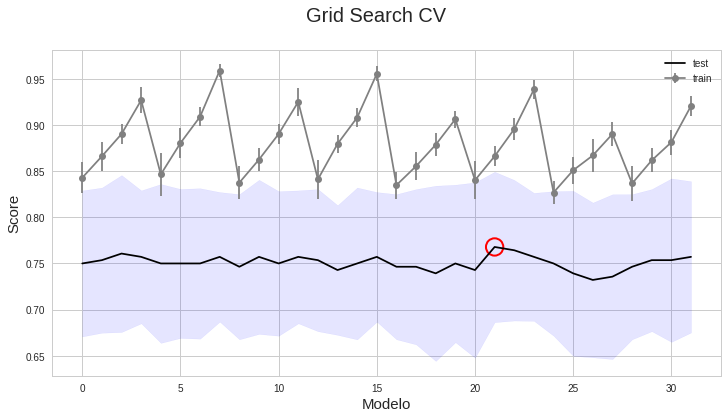

In [433]:
pipe =  Pipeline([('pca', PCA()), ('log_reg', LogisticRegression(solver='sag', max_iter=300, random_state=semilla))])


parameters = [{"log_reg__multi_class":["ovr", "multinomial"],"log_reg__C":[0.1, 0.05, 0.0094,0.005], 'pca__n_components':[50,80, 120,200]}]
# Realiza Grid Search
cvfolds = 5
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
#print('Best C:',GS.best_params_["svc__C"])
#print('Best Kernel:',GS.best_params_["svc__kernel"])
print('Best PCA:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

Best score: 0.7678571428571429


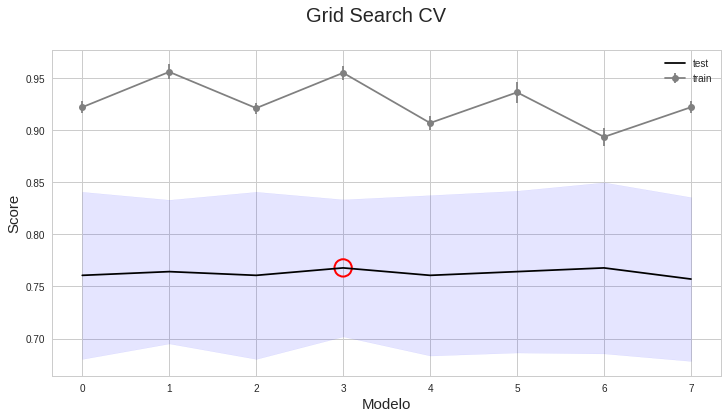

In [437]:
pipe =  Pipeline([('log_reg', LogisticRegression(solver='sag', max_iter=300, random_state=semilla))])


parameters = [{"log_reg__multi_class":["ovr", "multinomial"],"log_reg__C":[0.1, 0.05, 0.0094,0.005]}]
# Realiza Grid Search
cvfolds = 5
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
#print('Best C:',GS.best_params_["svc__C"])
#print('Best Kernel:',GS.best_params_["svc__kernel"])
#print('Best PCA:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

## LDA

Best score: 0.7535714285714287
Best PCA: 60


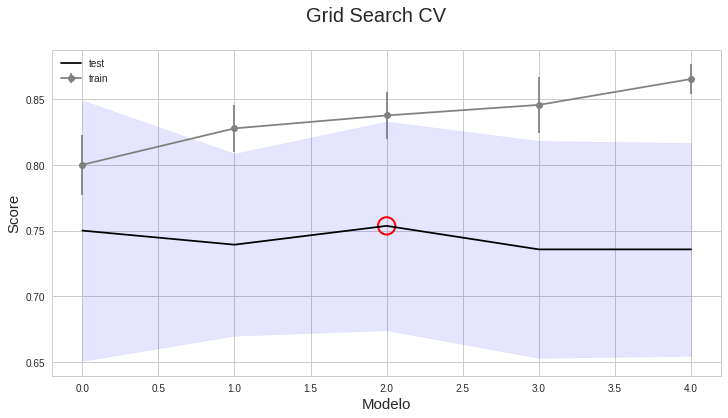

In [420]:
parameters = [{'pca__n_components':[30, 50, 60, 70, 80]}]
# Realiza Grid Search
cvfolds = 5
pipe =  Pipeline([('pca', PCA()), ('lda', LinearDiscriminantAnalysis(solver="svd", store_covariance=True))])
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
#print('Best C:',GS.best_params_["svc__C"])
#print('Best Kernel:',GS.best_params_["svc__kernel"])
print('Best PCA:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

## QDA

Best score: 0.6142857142857142
Best PCA: 80


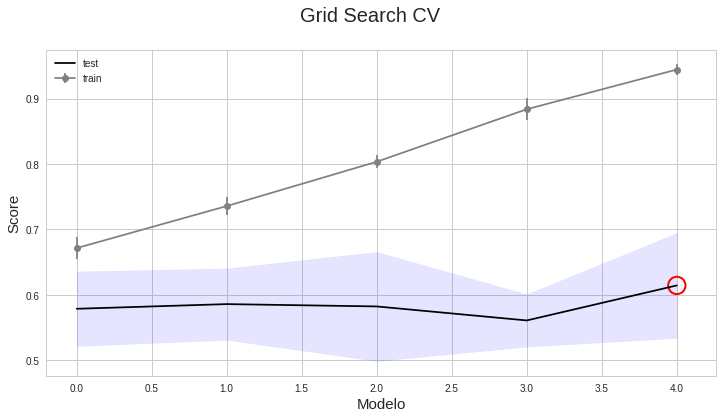

In [421]:
parameters = [{'pca__n_components':[30, 50, 60, 70, 80]}]
# Realiza Grid Search
cvfolds = 5
pipe =  Pipeline([('pca', PCA()), ('qda', QuadraticDiscriminantAnalysis(store_covariance=True))])
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
#print('Best C:',GS.best_params_["svc__C"])
#print('Best Kernel:',GS.best_params_["svc__kernel"])
print('Best PCA:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

## Redes neuronales

Best score: 0.7571428571428571


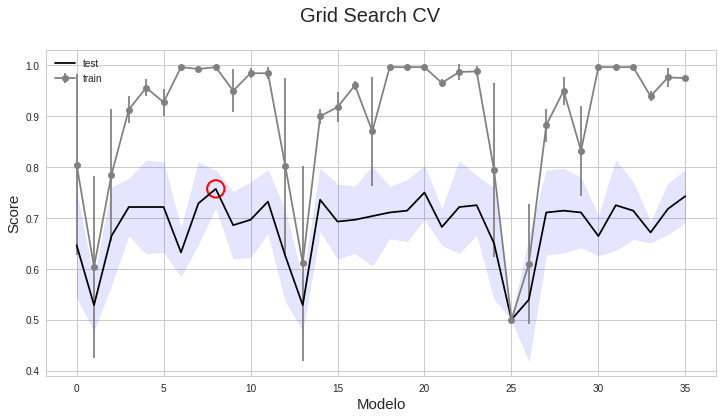

In [453]:
pipe =  Pipeline([('pca', PCA()), ("mlp", MLPClassifier(random_state=semilla, solver='lbfgs'))])


parameters = [
{'mlp__hidden_layer_sizes':[[1,1], [1,10], [10,10], [3,10]], 'mlp__alpha': [0.1, 0.5, 0.01], 'pca__n_components':[50, 80, 200]}]


cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

/home/enrique/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best score: 0.7821428571428571


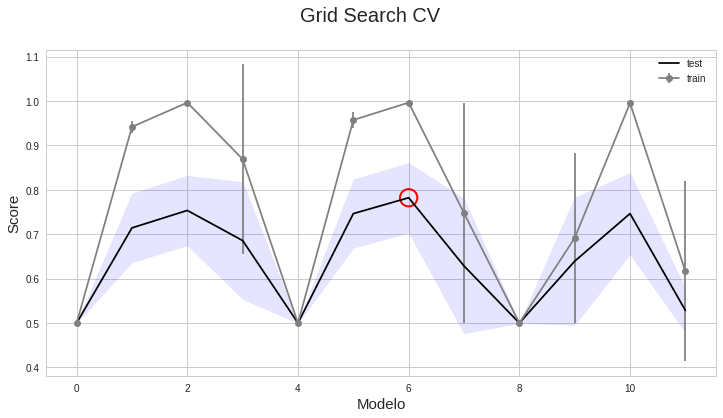

In [454]:
pipe =  Pipeline([("mlp", MLPClassifier(random_state=semilla, solver='lbfgs'))])

parameters = [
{'mlp__hidden_layer_sizes':[[1,1], [1,10], [10,10], [3,10]], 'mlp__alpha': [0.1, 0.5, 0.01]}]


cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

## SVC

/home/enrique/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best score: 0.7928571428571428
Best C: 0.01
Best Kernel: linear
Best Gamma: 200


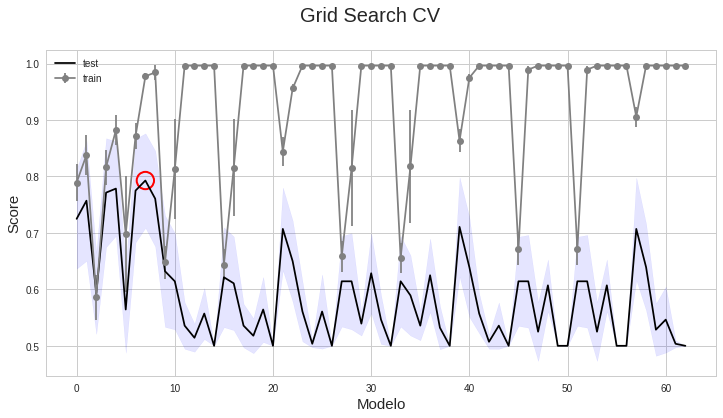

In [412]:
pipe =  Pipeline([('pca', PCA()), ('svc', SVC(max_iter=400))])

parameters = [
{'svc__C': [0.001, 0.01, 1], 'svc__kernel': ['linear'], 'pca__n_components':[50, 80, 200]},
    {'svc__C': [0.001, 0.01, 1], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10,100], 'svc__kernel': ['rbf'],
    'pca__n_components':[50, 80, 200]}]
# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["svc__C"])
print('Best Kernel:',GS.best_params_["svc__kernel"])
print('Best Gamma:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()


/home/enrique/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best score: 0.7928571428571428
Best C: 0.01
Best Kernel: linear


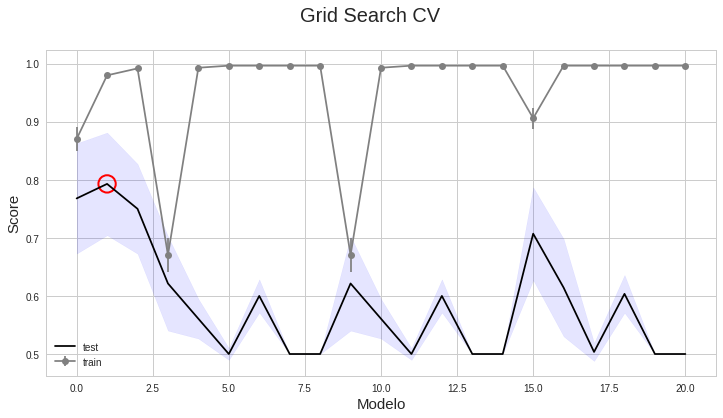

In [461]:
parameters = [
{'svc__C': [0.001, 0.01, 1], 'svc__kernel': ['linear']},
    {'svc__C': [0.001, 0.01, 1], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10,100], 'svc__kernel': ['rbf']}]
# Realiza Grid Search
cvfolds = 4
pipe =  Pipeline([('svc', SVC(max_iter=400))])
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["svc__C"])
print('Best Kernel:',GS.best_params_["svc__kernel"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()


AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

          no       0.68      0.83      0.75        60
         yes       0.79      0.62      0.69        60

    accuracy                           0.73       120
   macro avg       0.74      0.73      0.72       120
weighted avg       0.74      0.72      0.72       120



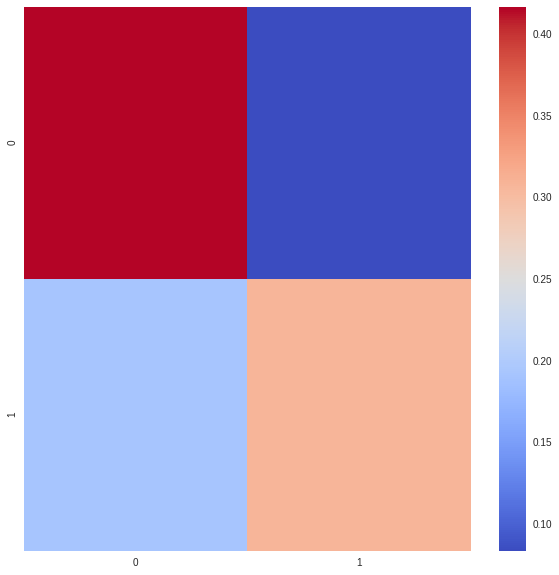

In [464]:
from sklearn import metrics
import seaborn as sns
y_predict = GS.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)/len(y_test)
fig, axs = plt.subplots(figsize=(10,10))
print(sns.heatmap(confusion_matrix, annot=False, cmap="coolwarm", xticklabels = True, yticklabels = True))
print(metrics.classification_report(y_test, y_predict))

## DecisionTreeClassifier

Best score: 0.6142857142857143
Best C: 2
Best Kernel: log2
Best Gamma: 80


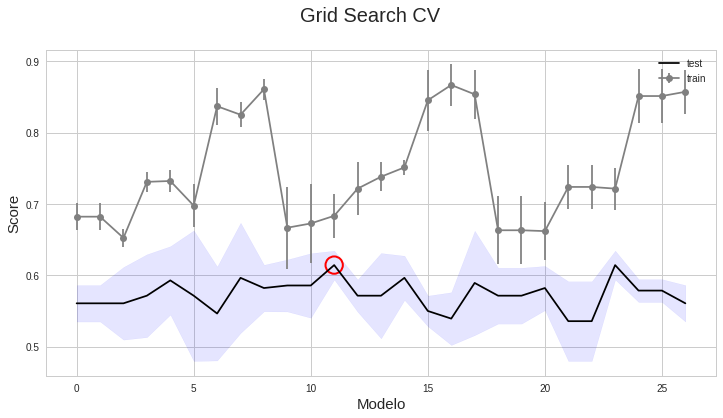

In [411]:
pipe =  Pipeline([('pca', PCA()), ('tree', DecisionTreeClassifier(random_state=semilla))])
parameters = [
{"tree__max_depth":[2, 3, 5], "tree__max_features":['auto', 'sqrt','log2'],
 'pca__n_components':[50, 80, 200]}]
# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["tree__max_depth"])
print('Best Kernel:',GS.best_params_["tree__max_features"])
print('Best Gamma:',GS.best_params_["pca__n_components"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

Best score: 0.5892857142857143
Best C: 5
Best Kernel: auto


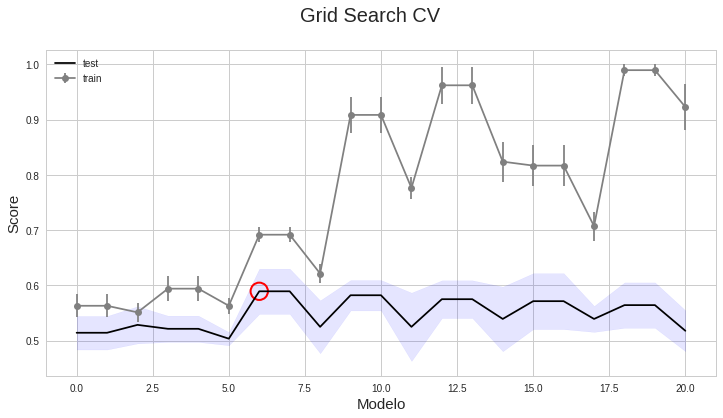

In [410]:
pipe =  Pipeline([('tree', DecisionTreeClassifier(random_state=semilla))])
parameters = [
{"tree__max_depth":[2,3,5, 15, 20, 10, 30], "tree__max_features":['auto', 'sqrt','log2']}]
# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["tree__max_depth"])
print('Best Kernel:',GS.best_params_["tree__max_features"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

## AdaBoost

In [459]:
?AdaBoostClassifier

Best score: 0.6857142857142857
Best C: 2
Best Kernel: log2


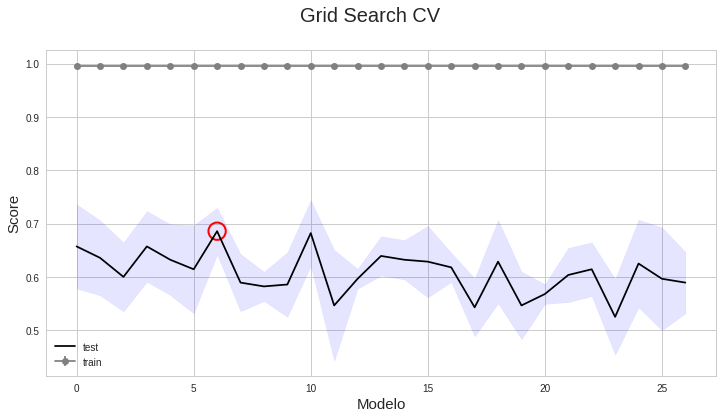

In [442]:
pipe =  Pipeline([('pca', PCA()), ('ada', AdaBoostClassifier(DecisionTreeClassifier(random_state=semilla)))])


parameters = [
{"ada__base_estimator__max_depth":[2, 3, 5], "ada__base_estimator__max_features":['auto', 'sqrt','log2'],
 'pca__n_components':[50, 80, 200]}]

# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["ada__base_estimator__max_depth"])
print('Best Kernel:',GS.best_params_["ada__base_estimator__max_features"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']


plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

In [457]:
?DecisionTreeClassifier

Best score: 0.6892857142857144
Best C: 200
Best Kernel: SAMME.R


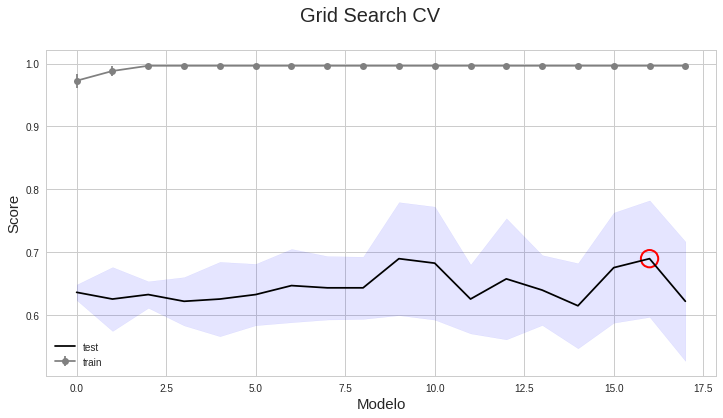

In [460]:
pipe =  Pipeline([('pca', PCA()), ('ada', AdaBoostClassifier(DecisionTreeClassifier(random_state=semilla, max_depth=1)))])


parameters = [
{"ada__n_estimators":[50, 100, 200], "ada__algorithm":['SAMME', 'SAMME.R'],
 'pca__n_components':[50, 80, 200]}]

# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["ada__n_estimators"])
print('Best Kernel:',GS.best_params_["ada__algorithm"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']


plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

Best score: 0.6321428571428571
Best C: 5
Best Kernel: auto


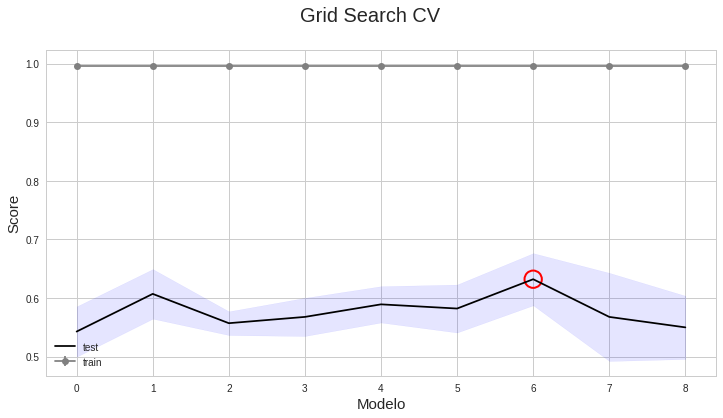

In [443]:
pipe =  Pipeline([('ada', AdaBoostClassifier(DecisionTreeClassifier(random_state=semilla)))])


parameters = [
{"ada__base_estimator__max_depth":[2, 3, 5], 
 "ada__base_estimator__max_features":['auto', 'sqrt','log2']}]

# Realiza Grid Search
cvfolds = 4
GS = GridSearchCV(estimator=pipe, param_grid=parameters, cv = cvfolds,
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

print('Best score:', GS.best_score_)
print('Best C:',GS.best_params_["ada__base_estimator__max_depth"])
print('Best Kernel:',GS.best_params_["ada__base_estimator__max_features"])

scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']


plt.style.use('seaborn-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (12, 6)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd,
                 alpha=0.1, color='blue')

plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),],
            s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray',
             ecolor='gray',label='train')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=20)
plt.legend(loc="best")
plt.show()

### Productos

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=3000)
corpus_sort_reviews_no = [corpus_prep3[i] for i in reviews_no_index]
corpus_sort_reviews_yes = [corpus_prep3[i] for i in reviews_yes_index]
corpus_prep33 = corpus_sort_reviews_no+corpus_sort_reviews_yes

producto_prep_no = [productos[i] for i in reviews_no_index]
producto_prep_yes = [productos[i] for i in reviews_yes_index]
producto_prep = producto_prep_no+producto_prep_yes


X = vectorizer.fit_transform(corpus_prep33)
bow = X.toarray()
bow_df = pd.DataFrame(bow,columns=vectorizer.get_feature_names())

y_tag = np.repeat("no", 200)
y_tag = np.concatenate([y_tag,np.repeat("yes", 200)])

X_train, X_test, y_train, y_test = train_test_split(bow_df, producto_prep, test_size=0.30, random_state=number_state)